In [2]:
# Data handling libraries
import pandas as pd
import numpy as np

# Web Scrapping and data obtension
import requests, zipfile, io
from bs4 import BeautifulSoup
import html5lib

# ML libraries
import gplearn as gp
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from sklearn.preprocessing import MinMaxScaler

# DataViz Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data model save
import pickle

In [3]:
# Plot format
plt.rcParams.update({'mathtext.default':'regular'}) # Latex in text
sns.set(context='notebook', font='Times New Roman', font_scale=1, style='ticks') # Formal style
%matplotlib notebook

In [4]:
### Download databases with some web scrapping by using the data from the official git repository
url = "https://github.com/CSSEGISandData/COVID-19/archive/master.zip"
html = requests.get(url,stream = True)

# Data is in a zip file, therefore we have to extract the files
z = zipfile.ZipFile(io.BytesIO(html.content))
z.extractall('./Files/info')

In [5]:
# Obtain the data8 Confirmed cases in the world in a time series format. 
small_path = "./Files/info/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series"

cases = {"confirmed_cases" : pd.read_csv(f'{small_path}/time_series_19-covid-Confirmed.csv'),
"death_cases" : pd.read_csv(f'{small_path}/time_series_19-covid-Deaths.csv'),
"recovered_cases" : pd.read_csv(f'{small_path}/time_series_19-covid-Recovered.csv')}

cases['confirmed_cases'].head()
cases['confirmed_cases'][cases['confirmed_cases']['Country/Region']=='Mexico']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
47,NaN,Mexico,23.6345,-102.5528,0,0,0,0,0,0,...,5,6,6,7,7,7,8,12,12,26


In [6]:
#Create a dictionary of the cases in time, for mainland china and for not mainland china
cases_general = {}
cases_words = ['confirmed','recovered','death']

# Define a variable for mainland and outside china:
location = ['mainland','outside']

for word in cases_words:
    # Empty dictionary
    cases_in_time = {}
    
    # Columns
    non_usable = 4

    # Confirmed cases only in china
    mainland_china = cases[f'{word}_cases'][cases[f'{word}_cases']['Country/Region'] == 'China']
    cases_in_time[f'{word}_mainland_china'] = np.array(mainland_china.sum()[non_usable:], dtype=float)

    #Confirmed cases in other places but china
    outside_china = cases[f'{word}_cases'][cases[f'{word}_cases']['Country/Region'] != 'China']
    cases_in_time[f'{word}_outside_china'] = np.array(outside_china.sum()[non_usable-2:], dtype=float)
    
    # Save in the dictionary each of the cases
    cases_general[word] = cases_in_time
data_dataframe = pd.concat([pd.DataFrame(cases_general[key] ) for key in cases_general.keys()], axis=1)

# Include the actual cases
for place in location:
    data_dataframe[f'actual_cases_{place}_china'] =  data_dataframe[f'confirmed_{place}_china']-(data_dataframe[f'death_{place}_china']+data_dataframe[f'recovered_{place}_china'])

# Include the actual cases into the cases_word
cases_words.append('actual_cases')

data_dataframe.head()

,confirmed_mainland_china,confirmed_outside_china,recovered_mainland_china,recovered_outside_china,death_mainland_china,death_outside_china,actual_cases_mainland_china,actual_cases_outside_china
0,548.0,7.0,28.0,0.0,17.0,0.0,503.0,7.0
1,643.0,10.0,30.0,0.0,18.0,0.0,595.0,10.0
2,920.0,21.0,36.0,0.0,26.0,0.0,858.0,21.0
3,1406.0,28.0,39.0,0.0,42.0,0.0,1325.0,28.0
4,2075.0,43.0,49.0,3.0,56.0,0.0,1970.0,40.0


In [7]:
# Change the scale (normalize by making the max value  = 1 and the min value = 0 ) 
# of the data with MinMaxScaler function
scaler = MinMaxScaler()
scaler.fit(data_dataframe)

# Normalization of the dataframe
norm_dataframe = pd.DataFrame(scaler.transform(data_dataframe))
norm_dataframe.columns = [f'norm_{element}' for element in data_dataframe.columns]
norm_dataframe.head()

,norm_confirmed_mainland_china,norm_confirmed_outside_china,norm_recovered_mainland_china,norm_recovered_outside_china,norm_death_mainland_china,norm_death_outside_china,norm_actual_cases_mainland_china,norm_actual_cases_outside_china
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.001181,0.000040,0.000030,0.000000,0.000315,0.0,0.001597,0.000046
2,0.004625,0.000186,0.000122,0.000000,0.002834,0.0,0.006163,0.000214
3,0.010668,0.000280,0.000168,0.000000,0.007872,0.0,0.014270,0.000320
4,0.018986,0.000479,0.000320,0.000431,0.012280,0.0,0.025467,0.000504


In [8]:
# Determine a numerical value for the dates

# We will use the dates in the dataset, to easily identify this, it is possible to use a common
# trait such as '/20'. 
timelapse = [pd.to_datetime(elem) for elem in cases['confirmed_cases'].columns if '/20' in elem]

time_numerical_value = [int(str(timelapse[i] - timelapse[0]).split(' ')[0]) for i in range(len(timelapse))]

# Time from the day Jan/22/20
time_information = pd.DataFrame([timelapse,time_numerical_value]).T
time_information.columns = ['date','numerical_value']

# Save the last date for the model:
last_date_for_model = str(list(time_information['date'])[-1]).split(' ')[0]

time_information.tail()

,date,numerical_value
48,2020-03-10,48
49,2020-03-11,49
50,2020-03-12,50
51,2020-03-13,51
52,2020-03-14,52


In [9]:
days = list(time_information.tail(1).numerical_value)[0]
startdate = time_information.date[0]
enddate = ['-'.join(str(pd.to_datetime(startdate) + pd.DateOffset(days=i)).split(' ')[0].split('-')[1:])
           for i in range(days+2)]

day_freq = 5


day_pos, day_text = [day_freq*i for i in range(len(enddate)//day_freq+1)],[enddate[day_freq*i] for i in range(len(enddate)//day_freq+1)]


In [10]:
# Create a dataframe with all the information

# All dataframes merged
cases_dataframe = pd.concat([time_information,data_dataframe,norm_dataframe],axis=1)

# Obtain the percentages

# death and recovered percentages` in different locations
for place in location:
    cases_dataframe[f'death_percentage_{place}_china'] = 100*cases_dataframe[f'death_{place}_china']/cases_dataframe[f'confirmed_{place}_china']
    cases_dataframe[f'recovered_percentage_{place}_china'] = 100*cases_dataframe[f'recovered_{place}_china']/cases_dataframe[f'confirmed_{place}_china']
    
# Show all the information
cases_dataframe.head()

,date,numerical_value,confirmed_mainland_china,confirmed_outside_china,recovered_mainland_china,recovered_outside_china,death_mainland_china,death_outside_china,actual_cases_mainland_china,actual_cases_outside_china,...,norm_recovered_mainland_china,norm_recovered_outside_china,norm_death_mainland_china,norm_death_outside_china,norm_actual_cases_mainland_china,norm_actual_cases_outside_china,death_percentage_mainland_china,recovered_percentage_mainland_china,death_percentage_outside_china,recovered_percentage_outside_china
0,2020-01-22,0,548.0,7.0,28.0,0.0,17.0,0.0,503.0,7.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.102190,5.109489,0.0,0.000000
1,2020-01-23,1,643.0,10.0,30.0,0.0,18.0,0.0,595.0,10.0,...,0.000030,0.000000,0.000315,0.0,0.001597,0.000046,2.799378,4.665630,0.0,0.000000
2,2020-01-24,2,920.0,21.0,36.0,0.0,26.0,0.0,858.0,21.0,...,0.000122,0.000000,0.002834,0.0,0.006163,0.000214,2.826087,3.913043,0.0,0.000000
3,2020-01-25,3,1406.0,28.0,39.0,0.0,42.0,0.0,1325.0,28.0,...,0.000168,0.000000,0.007872,0.0,0.014270,0.000320,2.987198,2.773826,0.0,0.000000
4,2020-01-26,4,2075.0,43.0,49.0,3.0,56.0,0.0,1970.0,40.0,...,0.000320,0.000431,0.012280,0.0,0.025467,0.000504,2.698795,2.361446,0.0,6.976744


<IPython.core.display.Javascript object>


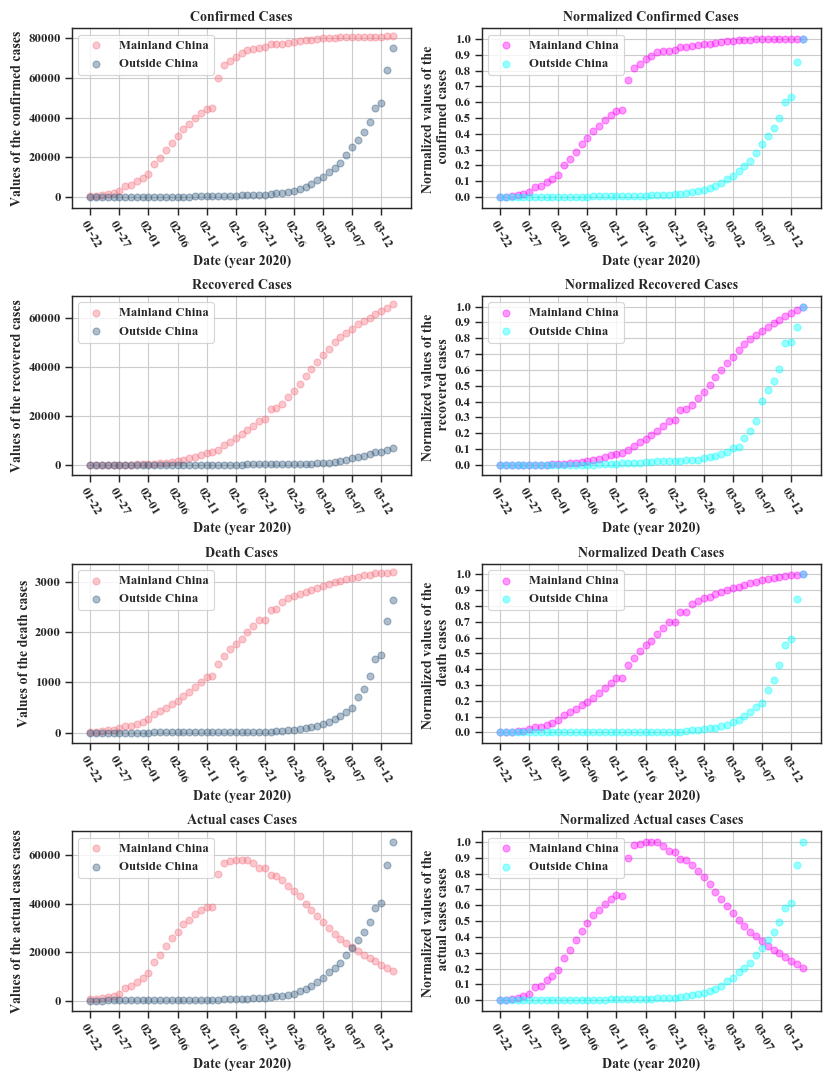

In [11]:
# Plots of the normalized traits and their importances

fig = plt.figure(figsize=(10,13))

# Some parameters for the plotting format
spacing = np.arange(0,int(max(cases_dataframe['numerical_value']))+2,step=3)
transparent = .4


color_plots = '#F67280', '#355C7D'
color_norm_plots = 'magenta','cyan'
# Plot the world cases. 
for pos,word in enumerate(cases_words):
    # All the cases (untransformed data)
    plt.subplot(len(cases_words),2,2*pos+1)
    
    # Scatter plot for place
    for i,place in enumerate(location): 
        plt.scatter(cases_dataframe['numerical_value'], cases_dataframe[f'{word}_{place}_china'],
                    color = color_plots[i], label = f'{place.capitalize()} China', alpha = transparent
                   )
    
    # Writen parameters of the plot
    plt.title(f'{word.capitalize().replace("_", " ")} Cases')
    plt.ylabel(f'Values of the {word.replace("_", " ")} cases')
    plt.xlabel('Date (year 2020)')
    
    # Grid and legend
    plt.xticks(day_pos,day_text, rotation = -60)
    plt.grid()
    plt.legend()
    
    # Normalized cases
    plt.subplot(len(cases_words),2,2*pos+2)
    
    #Scatter plot for normalized places
    for i,place in enumerate(location): 
        plt.scatter(cases_dataframe['numerical_value'], cases_dataframe[f'norm_{word}_{place}_china'],
                     color = color_norm_plots[i], label = f'{place.capitalize()} China', alpha = transparent
                    )
    
    # Written parameters of the plot
    plt.title(f'Normalized {word.capitalize().replace("_", " ")} Cases')
    plt.ylabel(f'Normalized values of the \n {word.replace("_", " ")} cases')
    plt.xlabel('Date (year 2020)')
    
    # Grid and legends
    plt.yticks(np.arange(0,1.1,step=.1))
    plt.xticks(day_pos,day_text, rotation = -60)
    plt.grid()
    plt.legend()

# Automatically modify the position of the plots
plt.tight_layout()

<IPython.core.display.Javascript object>


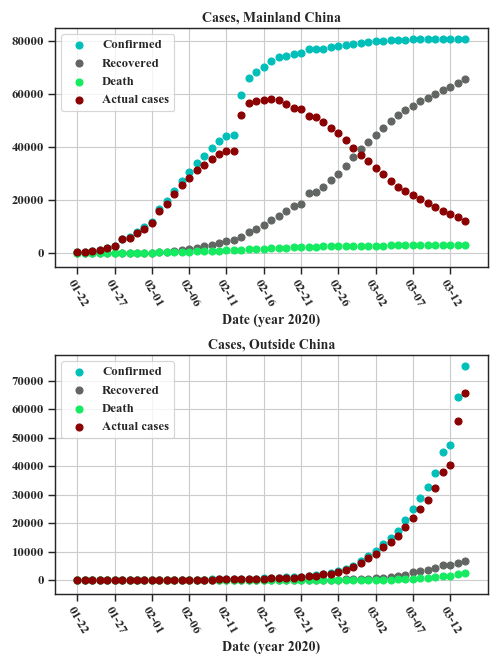

In [12]:
# Select colors for the plots
colors = ['#00bfb9', '#626663', '#15eb60','#8B0000']

# Plot the data for the number of cases
plt.figure(figsize=(6,8))
for position,place in enumerate(location):
    
    # Generate two subplots, for the different places
    plt.subplot(2,1,position+1)
    for i,word in enumerate(cases_words):
        
        # Scatter for every case
        plt.scatter(cases_dataframe['numerical_value'], cases_dataframe[f'{word}_{place}_china'],
                    color = colors[i], label = word.capitalize().replace('_',' '))
        
    plt.title(f'Cases, {place.capitalize()} China')
    plt.xticks(day_pos,day_text,rotation=-60)
    plt.xlabel('Date (year 2020)')
    plt.grid()
    plt.legend()
        
plt.tight_layout()

In [13]:
# Non dependeant variable for regressions (numerical value of the date).
X0_DATA = np.array(cases_dataframe['numerical_value'],dtype=float).reshape(-1,1)

In [14]:
# Use the Symbolic Regressor for normalized data

# Define an exponential operator to create a symbolic function
def _protected_exponent(x1):
    with np.errstate(over='ignore'):
        return np.where(np.abs(x1) < 100, np.exp(x1), 0.)
    
# Create a compatible function with the list for the function_set
exponential = make_function(function=_protected_exponent, name='exp', arity=1)

# Function List
f_list = ['add','sub','mul', exponential]
# Create an empty dictionary which will contain two Symbolic Regressors, depending on the location
estimator_symbolic_reg = {}
for place in location:
    # Create a Symbolic Regressor object (estimator genetic predictor)
    estimator_symbolic_reg[place] =  [SymbolicRegressor(population_size = 1000,
                                       generations = 10,
                                       stopping_criteria = 0.001,
                                       function_set = f_list,
                                       p_crossover = 0.70,
                                       p_subtree_mutation = 0.20,
                                       max_samples = 0.97,
                                       verbose = 1,
                                       parsimony_coefficient = 0.001) for i in range(len(cases_words))]

In [18]:
# Fit the data to each of the Symbolic Regressor Objects
for i in range(len(cases_words)):
    for place in location:
        estimator_symbolic_reg[place][i].fit(X0_DATA , cases_dataframe[f'norm_{cases_words[i]}_{place}_china'])
    print('')

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    28.24      7.48233e+90       12         0.178199         0.289541      8.12s
   1    15.12      5.40711e+38        6         0.120553         0.082014      5.52s
   2    20.76      4.56177e+38       19         0.110814        0.0663067      4.96s
   3    19.48       5.1985e+42       15        0.0819138        0.0491924      4.30s
   4    15.78      9.81087e+38       27        0.0312433        0.0810603      3.42s
   5    18.00      1.77849e+39       18        0.0264233       0.00493916      2.78s
   6    21.20      1.81066e+38       12        0.0298607         0.043409      2.51s
   7    21.18      5.82645e+38       19         0.021999        0.0048857      1.59s
   8    20.10      3.07428e+38       22        0.0192737        0.0867123  

   4     8.30      5.94869e+40       17        0.0771617         0.433967      2.85s
   5    10.44      2.64348e+80       19        0.0753676         0.537755      2.40s
   6    10.71      1.38728e+41       15        0.0712901         0.537755      1.88s
   7    10.65      3.21113e+40       13        0.0776606         0.361433      1.25s
   8    10.48      2.11927e+40       21        0.0731225         0.505608      0.68s
   9    12.78      7.20777e+41       16         0.074812         0.291402      0.00s



In [19]:
# Show the results
for i in range(len(cases_words)):
    for place in location:
        sym_reg = estimator_symbolic_reg[place][i]
        # Show the program
        print(f'{cases_words[i]}: {sym_reg._program}')
        
        # Delete past generations
        delattr(sym_reg,'_programs')
        
        # Save the model
        with open(f'./Results/Covid_19_symbolic_regression_model_{cases_words[i]}_{place}_{last_date_for_model}.pkl','wb') as f:
            pickle.dump(sym_reg,f)
    print('')

confirmed: exp(mul(exp(mul(X0, -0.132)), sub(sub(sub(0.879, 0.796), mul(X0, -0.132)), exp(sub(exp(0.156), -0.981)))))
confirmed: mul(mul(mul(mul(0.005, add(0.232, -0.049)), X0), mul(mul(add(0.001, 0.005), mul(X0, X0)), mul(mul(add(sub(X0, X0), 0.005), exp(exp(mul(exp(add(X0, X0)), sub(-0.802, X0))))), exp(0.412)))), X0)

recovered: mul(mul(add(add(-0.925, 0.690), mul(X0, 0.029)), 0.690), add(mul(-0.323, 0.531), mul(X0, 0.029)))
recovered: exp(sub(mul(exp(mul(X0, -0.563)), sub(-0.303, 0.557)), exp(add(X0, X0))))

death: exp(mul(exp(mul(X0, -0.141)), sub(sub(-0.255, 0.614), X0)))
death: sub(X0, X0)

actual_cases: mul(-0.550, -0.856)
actual_cases: exp(sub(exp(-0.349), add(exp(add(X0, X0)), exp(exp(add(exp(X0), exp(0.552)))))))



In [20]:
def polyfits_to_data(x,y,order,data):
    # Values of the polynomial regression:
    value = np.polyfit(x,y,order)
    
    # Numpy array of the data
    data = np.array(data)
    # Polynomial values
    ans = sum([value[v]*data**(order-v) for v in range(order)])
    
    return ans

In [43]:
# Values for predicitons
x_data = X0_DATA.flatten() # Discrete values
x_values = np.linspace(0,days+7,1000) # Continuous values

# Predictions for polynomial regressions
order = [5,6,5,4]
poly_regressions = {}
poly_regressions_discrete = {}
poly_column_names = []

# Predictions for the symbolic regressions
symb_regressions = {}
symb_regressions_discrete = {}
symb_column_names=[]

for i in range(len(cases_words)):
    for place in location:
        # Polynomial Regression predictions 
        
        txt_poly = f"{cases_words[i]}_{place}_poly_reg"
        poly_pred = polyfits_to_data(x_data,
                              cases_dataframe[f'{cases_words[i]}_{place}_china'], 
                              order[i], 
                              x_values )
        poly_discrete_pred = polyfits_to_data(x_data,
                              cases_dataframe[f'{cases_words[i]}_{place}_china'], 
                              order[i], 
                              x_data )
        poly_regressions[txt_poly] = poly_pred
        poly_regressions_discrete[txt_poly] = poly_discrete_pred
        poly_column_names.append(txt_poly)
        
        
        # Symbolic Regression predictions
        txt_symb = f"{cases_words[i]}_{place}_symb_reg"
        symb_regressions[txt_symb] = estimator_symbolic_reg[place][i].predict(x_values.reshape(-1,1))
        symb_regressions_discrete[txt_symb] = estimator_symbolic_reg[place][i].predict(X0_DATA)
        symb_column_names.append(txt_symb)
        
# Obtain a DF with all the predictions of the polynomial regression
poly_reg = pd.DataFrame(poly_regressions)
poly_reg.columns = poly_column_names

# Obtian a DF with all the discrete values predicted from the polynomial regression
values_poly_reg = pd.DataFrame(poly_regressions_discrete)
values_poly_reg.columns = poly_column_names
        
# Obtain a DF with all the predictions of the symbolic regression
symb_reg = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(symb_regressions)))
symb_reg.columns = symb_column_names

# Obtain a DF with all the discrete values predicted from the symbolic regression
values_symb_reg = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(symb_regressions_discrete)))
values_symb_reg.columns = symb_column_names

In [ ]:
x_real_vals = np.array(cases_dataframe['numerical_value'])

prediction_values={}
for i in range(len(cases_words)):
    coef_max,coef_min = scaling_coef[cases_words[i]]
    prediction_values[cases_words[i]] = est_gp[i].predict(x_real_vals.reshape(-1,1))*(coef_max-coef_min)+coef_min

In [ ]:
# Retrieve texts by including the equations found in the symbolic regression and
# the values obtained from the scaling_coef variables

texts = ['106.74888 x^2 + 325','2.96112 x^2', '0.018017963238x^4 + 25']

In [ ]:
colors = ['#00bfb9', '#626663', '#15eb60']
plt.figure(figsize=(9,12))

for i in range(len(cases_words)):
    # Distinct Cases
    plt.subplot(len(cases_words),1,i+1)
    
    # Plot an individual case
    y_poly = regressions[cases_words[i]]['y_poly_scaled']
    y_symb = regressions[cases_words[i]]['y_symb_scaled']
    
    plt.plot(x_vals, y_poly, color='purple', label = 'Polynomial Regression', alpha = .4)
    plt.plot(x_vals, y_symb, color= 'blue', label = 'Symbolic Regression')
    
    plt.text(x_vals[len(x_vals)//10], y_symb[3*len(y_symb)//4], s=f"f(x) = ${texts[i]}$", c = '#bf5600' )
    # Plot the real data
    plt.scatter(cases_dataframe['numerical_value'], 
                cases_dataframe[f'{cases_words[i]}_mainland_china'],
                color = colors[i], label = f"China's {cases_words[i]} cases",s=90, alpha=.9,edgecolors="#d8db00")

    # Determine the maximum and minimum values  for the box
    max_val = np.max([np.max(regressions[cases_words[i]]['y_symb_scaled']),
                      np.max(regressions[cases_words[i]]['y_poly_scaled'])])
    min_val = np.min([np.min(regressions[cases_words[i]]['y_symb_scaled']),
                      np.min(regressions[cases_words[i]]['y_poly_scaled'])])
    
    # Delimit the window and write the grid
    plt.ylim(0,max_val)
    plt.xlim(-1,days)
    plt.grid()

    
    # Write the ticks for the plot
    plt.xticks([i for i in range(days)], enddate, rotation=-60)
    plt.yticks(np.arange(0,max_val,step=(max_val-min_val)/10))

    # Write the labels
    plt.xlabel('Date (year 2020)')
    plt.ylabel(f'{cases_words[i].capitalize()} Cases')
    plt.title(f'Prediction on the {cases_words[i]} cases with different regressions', fontsize=14)
    plt.title(f'Prediction on the {cases_words[i]} cases', fontsize=14)
    
    # Include legend
    plt.legend(loc = "upper left", bbox_to_anchor = (1,1))

plt.tight_layout()

In [ ]:
colors = ['#00bfb9', '#626663', '#15eb60']
plt.figure(figsize=(9,12))

for i in range(len(cases_words)):
    # Distinct Cases
    plt.subplot(len(cases_words),2,2*i+1)
    
    # Plot the real data
    plt.scatter(cases_dataframe['numerical_value'], 
                cases_dataframe[f'{cases_words[i]}_mainland_china'],
                color = colors[i], label = f"China's {cases_words[i]} cases",s=90, alpha=.9,edgecolors="#d8db00")

    # Plot the predicted data
    plt.scatter(x_real_vals, prediction_values[cases_words[i]],
                color= 'blue', label = 'Predicted by Symbolic Regression', alpha=.4)

    # Delimit the window and write the grid
    plt.xlim(-1,days)
    plt.grid()
    # Write the ticks for the plot
    plt.xticks([day_freq*i for i in range(len(enddate)//day_freq+1)], [enddate[day_freq*i] for i in range(len(enddate)//day_freq+1)], rotation=-60)

    
    # Write the labels
    plt.xlabel('Date (year 2020)')
    plt.ylabel(f'{cases_words[i].capitalize()} Cases')
    plt.title(f'Prediction on the {cases_words[i]} cases with different regressions', fontsize=14)
    plt.title(f'Prediction on the {cases_words[i]} cases', fontsize=14)
    
    # Include legend
    plt.legend()
    
    plt.subplot(len(cases_words),2,2*i+2)
    
    # Plot the error
    squared_error = (prediction_values[cases_words[i]]-cases_dataframe[f'{cases_words[i]}_mainland_china'])**2/100000
    
    plt.plot(x_real_vals, np.mean(squared_error)*np.ones(len(x_real_vals)),c='r', label = 'MSE')

    plt.plot(cases_dataframe['numerical_value'], 
                squared_error,
                color = 'orange', marker = 'o',
                label = f"Error for China's {cases_words[i]} cases", alpha=.3)

    # Delimit the window and write the grid
    plt.xlim(-1,days)
    plt.grid()
    # Write the ticks for the plot
    plt.xticks([day_freq*i for i in range(len(enddate)//day_freq+1)], 
               [enddate[day_freq*i] for i in range(len(enddate)//day_freq+1)],
               rotation=-60)

    # Write the labels
    plt.xlabel('Date (year 2020)')
    plt.ylabel(f'Squared Error of the {cases_words[i].capitalize()} Cases')
    plt.title(f'Prediction on the {cases_words[i]} cases with different regressions', fontsize=14)
    plt.title(f'Error on the prediction \n of the {cases_words[i]} cases', fontsize=14)
    
    # Include legend
    plt.legend()
    
plt.tight_layout()

In [ ]:
days2 = 60
enddate2 = ['-'.join(str(pd.to_datetime(startdate) + pd.DateOffset(days=i)).split(' ')[0].split('-')[1:]) for i in range(days2+2)]
future_vals = np.linspace(0,days2,100000)


plt.figure(figsize=(9,12))

future_predictions = {}

equal_value = pd.DataFrame(future_vals.reshape(-1, 1), columns=['x'])
for i in range(len(cases_words)):
    y_max, y_min = scaling_coef[cases_words[i]]
    # Predictions for the symbolic regression
    future_predictions[cases_words[i]] = {}
    future_predictions[cases_words[i]]['y_symb'] = est_gp[i].predict(future_vals.reshape(-1, 1))
    future_predictions[cases_words[i]]['y_symb_scaled'] = future_predictions[cases_words[i]]['y_symb']*(y_max-y_min)+(y_min)
        
    # Plot an individual case    
    #plt.plot(x_vals, y_poly, color='purple', label = 'Polynomial Regression', alpha = .4)
    plt.plot(future_vals, future_predictions[cases_words[i]]['y_symb_scaled'], color= colors[i], label = f'{cases_words[i]}')

    equal_value[cases_words[i]] = future_predictions[cases_words[i]]['y_symb_scaled']
    
    # Delimit the window and write the grid
    plt.xlim(-1,days2)
    plt.grid()

    
    # Write the ticks for the plot
    day_spam = 5
    plt.xticks([day_spam*i for i in range(len(enddate2)//day_spam)], [enddate2[day_spam*i] for i in range(len(enddate2)//day_spam)], rotation=-60)
    #plt.yticks(np.linspace(-0))

    # Write the labels
    plt.xlabel('Date (year 2020)')
    plt.ylabel(f'{cases_words[i].capitalize()} Cases')
    plt.title(f'Prediction on the {cases_words[i]} cases with different regressions', fontsize=14)
    plt.title(f'Prediction on the {cases_words[i]} cases', fontsize=14)
    
    plt.scatter(cases_dataframe['numerical_value'], 
         cases_dataframe[f'{cases_words[i]}_mainland_china'])
    
    # Include legend
    plt.legend(loc = "upper left", bbox_to_anchor = (1,1))
equal_value['difference'] = abs(equal_value['confirmed']-equal_value['recovered'])

plt.tight_layout()
equal_value_coordinate = equal_value[equal_value['difference'] == equal_value['difference'].min()]#[equal_value.difference<10]
plt.scatter(equal_value_coordinate.x,equal_value_coordinate.recovered)

In [ ]:
plt.figure(figsize=(12,12))

for i in range(len(cases_words)):
    
    # Velocity plots
    plt.subplot(len(cases_words),2,2*i+1)
    
    # Determine the velocity as the gradiento of the equation
    speed_poly = np.gradient(regressions[cases_words[i]]['y_poly_scaled'])
    speed_symb = np.gradient(regressions[cases_words[i]]['y_symb_scaled'])
    # Plot the values
    plt.plot(x_vals,speed_poly , color='#0dd141', label = 'Polynomial Regression', alpha = .4)
    plt.plot(x_vals,speed_symb , color='r', label = 'Symbolic Regression')
        
    # Determine maximum and minimum values for the window
    max_val_speed = np.max([np.max(speed_poly),
                      np.max(speed_symb)])
    min_val_speed = np.min([np.min(speed_poly),
                      np.min(speed_symb)])
    
    # Delimit the box
    plt.ylim(min_val_speed,max_val_speed)
    plt.xlim(0,days)

    # Use a written for x and y ticks and grid
    day_spam = 5
    plt.xticks([day_spam*i for i in range(len(enddate2)//day_spam)], [enddate2[day_spam*i] for i in range(len(enddate2)//day_spam)], rotation=-60)
    plt.yticks(np.arange(min_val_speed,max_val_speed,step=(max_val_speed-min_val_speed)/10))
    plt.grid()

    # Write the labels
    plt.xlabel('Date (year 2020)')
    plt.ylabel(f'{cases_words[i].capitalize()} Cases')    
    plt.title(f'Speed of the {cases_words[i]} cases', fontsize=14)
    
    # Legend
    plt.legend()

    # Acceleration plots
    plt.subplot(len(cases_words),2,2*i+2)
    
    # Determine the acceleration as the gradiento of the velocity
    acc_poly = np.gradient(speed_poly)
    acc_symb = np.gradient(speed_symb)
    
    #Plot the values
    plt.plot(x_vals,acc_poly , color='#d1830d', label = 'Polynomial Regression', alpha = .4)
    plt.plot(x_vals,acc_symb , color= '#d10dc7', label = 'Symbolic Regression')

    # Delimit the box
    plt.xlim(0,days-2)

    # Use a written for x and y ticks and grid
    day_spam = 2
    #plt.xticks([day_spam*i for i in range(len(enddate)//day_spam)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam)], rotation=-60)
    plt.grid()

    # Write the labels
    plt.xlabel('Date (year 2020)')
    plt.ylabel(f'{cases_words[i].capitalize()} Cases')
    plt.title(f'Acceleration of the {cases_words[i]} cases', fontsize=14)
    
    # Legend
    plt.legend()
    
plt.tight_layout()

In [ ]:
# Determine the death  and recovered percentage functions
death_percentage = 100*regressions['death']['y_symb_scaled']/regressions['confirmed']['y_symb_scaled']
recovered_percentage = 100*regressions['recovered']['y_symb_scaled']/regressions['confirmed']['y_symb_scaled']

plt.figure(figsize=(8,5))

# Real data
plt.subplot(121)

plt.plot(cases_dataframe['numerical_value'], cases_dataframe['death_percentage_mainland_china'],
         color = 'black', marker='o',alpha=.3, linewidth=1, label = 'Death Percentage')
plt.plot(cases_dataframe['numerical_value'], cases_dataframe['recovered_percentage_mainland_china'],
         color = 'green', marker= 'o',alpha=.3,linewidth=1, label = 'Recovered Percentage')

#plt.xticks([5*i for i in range(5+1)], [enddate[5*i] for i in range(5+1)], rotation=-60)
plt.xlim(0,25)
plt.ylim(0,15)
plt.grid()
plt.legend()

plt.title('Death and Recovery Percentage\n Cases (Real data)')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')


# Predicted data
plt.subplot(122)

plt.plot(x_vals, death_percentage, color ='black',label = 'Death Percentage')
plt.plot(x_vals, recovered_percentage, color = 'green', label = 'Recovered Percentage')

day_spam = 4
#plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.xlim(0,25)
plt.ylim(0,15)
plt.grid()
plt.legend()

plt.title('Death and Recovery Percentage\n Cases (Predicted data)')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')

plt.tight_layout()

In [ ]:
plt.figure(figsize = (8,8))

plt.subplot(221)

plt.plot(x_real_vals, cases_dataframe['death_percentage_mainland_china'],
         color = 'black', marker='o',alpha=.3, linewidth=1, label = 'Death Percentage')

y_death_predictions = 100*(prediction_values['death']/prediction_values['confirmed'])

plt.scatter(x_real_vals, y_death_predictions, color = 'blue',alpha=.3)

day_spam = 4
#plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.title(' Death Percentage Cases')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')
plt.grid()


plt.subplot(222)

plt.plot(x_real_vals, cases_dataframe['recovered_percentage_mainland_china'],
         color = 'green', marker= 'o',alpha=.3,linewidth=1, label = 'Recovered Percentage')

y_recovered_predictions = 100*(prediction_values['recovered']/prediction_values['confirmed'])

plt.scatter(x_real_vals, y_recovered_predictions, color = 'blue',alpha=.3)

day_spam = 4
#plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.title('Recovery Percentage  Cases')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')
plt.grid()
plt.tight_layout()



plt.subplot(223)
squared_error_death = (cases_dataframe['death_percentage_mainland_china']-y_death_predictions)**2
plt.plot(x_real_vals, squared_error_death,
         color = 'orange', marker='o',alpha=.3, linewidth=1, label = 'Death Percentage')
plt.plot(x_real_vals, np.mean(squared_error_death)*np.ones(len(x_real_vals)),c='r')


day_spam = 4
#plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.title('Square Error from the Death Percentage Cases')
plt.xlabel('Date (year 2020)')
plt.ylabel('Square Error of the Percentage')
plt.grid()


plt.subplot(224)
squared_error_recovered = (cases_dataframe['recovered_percentage_mainland_china']-y_recovered_predictions)**2
plt.plot(x_real_vals, squared_error_recovered ,
         color = 'orange', marker= 'o',alpha=.3,linewidth=1, label = 'Recovered Percentage')

plt.plot(x_real_vals, np.mean(squared_error_recovered)*np.ones(len(x_real_vals)),c='r')

day_spam = 4
#plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.title('Square Error from the Recovery Percentage  Cases')
plt.xlabel('Date (year 2020)')
plt.ylabel('Square Error of the Percentage')
plt.grid()
plt.tight_layout()

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(x_vals, death_percentage, color ='black',label = 'Death Percentage')
plt.plot(x_vals[10:], recovered_percentage[10:], color = 'green', label = 'Recovered Percentage')

day_spam = 5
plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.ylim(0,np.max([np.max(death_percentage),np.max(recovered_percentage)]))
plt.xlim(0,days)

plt.grid()
plt.legend()

plt.title('Death and Recovery Percentage Cases')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')

plt.tight_layout()